In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install optuna > /dev/null

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [4]:
tf.random.set_seed(47)
np.random.seed(47)

In [5]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [6]:
plt.rcParams['figure.figsize'] = (16,6)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving CELH (1).csv to CELH (1).csv


In [9]:
df = pd.read_csv('CELH (1).csv')
df['Date'] = pd.to_datetime(df.Date)

In [10]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date      Open     Close       Low      High  Adj Close
0 2010-01-04  1.666667  1.666667  1.666667  1.683333   1.666667
1 2010-01-05  1.666667  1.790000  1.500000  1.796667   1.790000
2 2010-01-06  1.816667  1.783333  1.666667  1.816667   1.783333
3 2010-01-07  1.683333  1.683333  1.683333  1.783333   1.683333
4 2010-01-08  1.700000  1.773333  1.586667  1.776667   1.773333


In [11]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,2640,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,2015-04-01 01:20:43.636363776,0.759029,0.760208,0.733348,0.784380,0.760208
min,2010-01-04 00:00:00,0.050000,0.050000,0.046667,0.050000,0.050000
25%,2012-08-14 18:00:00,0.130000,0.133333,0.120000,0.133333,0.133333
50%,2015-04-01 12:00:00,0.666667,0.666667,0.643333,0.683333,0.666667
75%,2017-11-10 18:00:00,1.300000,1.307500,1.263333,1.333333,1.307500
max,2020-06-29 00:00:00,3.803333,3.853333,3.570000,3.993333,3.853333
std,NaN,0.652677,0.653364,0.634588,0.673063,0.653364


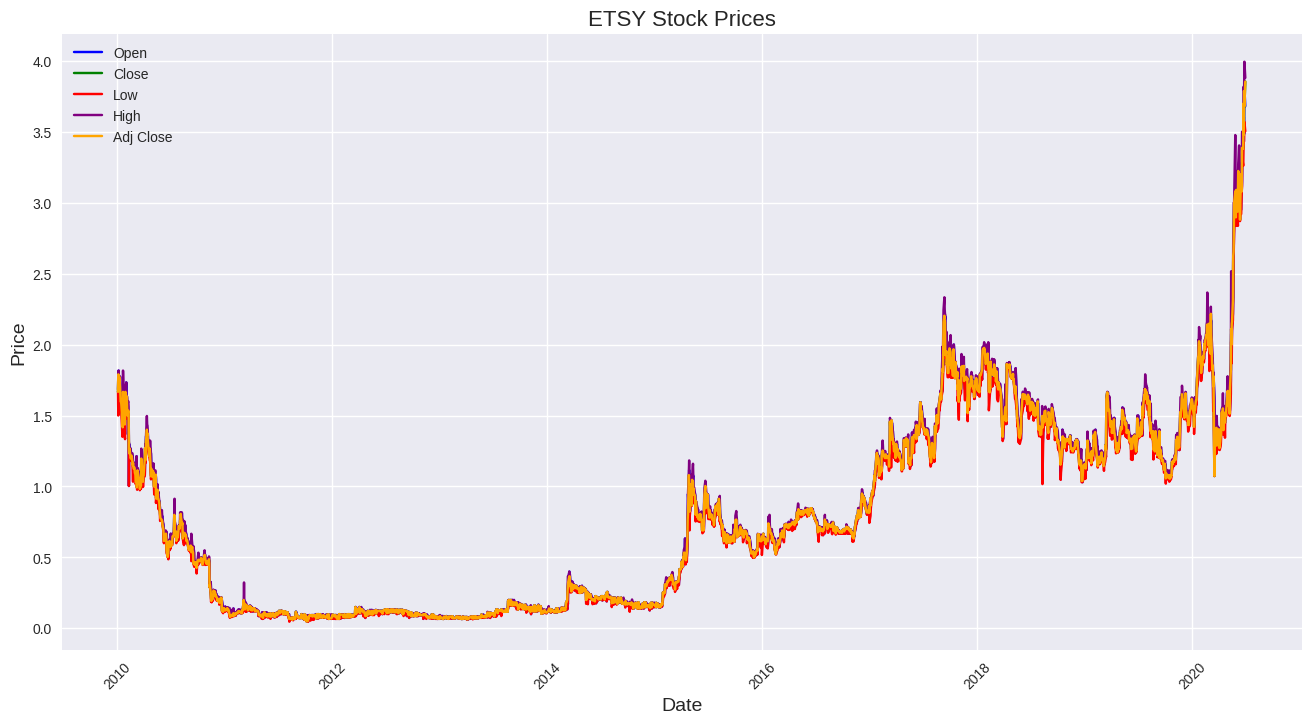

In [12]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('ETSY Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [13]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date      Open     Close       Low      High  Adj Close  avg_price  \
0 2010-01-05  1.666667  1.790000  1.500000  1.796667   1.790000   1.708667   
1 2010-01-06  1.816667  1.783333  1.666667  1.816667   1.783333   1.773333   
2 2010-01-07  1.683333  1.683333  1.683333  1.783333   1.683333   1.703333   
3 2010-01-08  1.700000  1.773333  1.586667  1.776667   1.773333   1.722000   
4 2010-01-11  1.773333  1.700000  1.666667  1.773333   1.700000   1.722667   

    returns  
0  2.315365  
1  3.784623  
2 -3.947391  
3  1.095910  
4  0.038711  


In [14]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date      Open     Close       Low      High  Adj Close   returns
0 2010-01-05  1.666667  1.790000  1.500000  1.796667   1.790000  2.315365
1 2010-01-06  1.816667  1.783333  1.666667  1.816667   1.783333  3.784623
2 2010-01-07  1.683333  1.683333  1.683333  1.783333   1.683333 -3.947391
3 2010-01-08  1.700000  1.773333  1.586667  1.776667   1.773333  1.095910
4 2010-01-11  1.773333  1.700000  1.666667  1.773333   1.700000  0.038711


In [15]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (2639, 7)
[[Timestamp('2010-01-05 00:00:00') 1.666667 1.79 ... 1.796667 1.79
  2.3153649921718644]
 [Timestamp('2010-01-06 00:00:00') 1.816667 1.783333 ... 1.816667
  1.783333 3.784623192772263]
 [Timestamp('2010-01-07 00:00:00') 1.683333 1.683333 ... 1.783333
  1.683333 -3.9473908290454496]
 ...
 [Timestamp('2020-06-25 00:00:00') 3.483333 3.786667 ... 3.79 3.786667
  2.7158682418381153]
 [Timestamp('2020-06-26 00:00:00') 3.803333 3.68 ... 3.993333 3.68
  2.443468271334792]
 [Timestamp('2020-06-29 00:00:00') 3.68 3.853333 ... 3.88 3.853333
  0.2313973026485172]]


In [16]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (2639, 6)
[[ 1.666667    1.79        1.5         1.796667    1.79        2.31536499]
 [ 1.816667    1.783333    1.666667    1.816667    1.783333    3.78462319]
 [ 1.683333    1.683333    1.683333    1.783333    1.683333   -3.94739083]
 ...
 [ 3.483333    3.786667    3.433333    3.79        3.786667    2.71586824]
 [ 3.803333    3.68        3.57        3.993333    3.68        2.44346827]
 [ 3.68        3.853333    3.503333    3.88        3.853333    0.2313973 ]]


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(2507, 6)
(66, 6)
(66, 6)


In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 2506
Validation Samples: 65
Test Samples: 65


In [23]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [24]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(2506,) (65,) (65,)


In [25]:
x_train[1], y_train[0]

(array([[0.80916058, 0.80495353, 0.76415094, 0.77372289, 0.80495353,
         0.50194305]]),
 0.8091605815512338)

In [26]:
x_val[1], y_val[0]

(array([[0.64427506, 0.64241481, 0.64779858, 0.63065703, 0.64241481,
         0.44639946]]),
 0.6442750601946656)

In [27]:
x_test[1], y_test[0]

(array([[0.5877862 , 0.61145536, 0.58647783, 0.6014598 , 0.61145536,
         0.46946234]]),
 0.5877861966085797)

In [28]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [29]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, Dense, Dropout, Reshape, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np

In [30]:
%%time
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]

    x_train_reshaped = x_train.reshape((x_train.shape[0], n_timesteps, 1, n_features, 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], n_timesteps, 1, n_features, 1))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         input_shape=(n_timesteps, 1, n_features, 1),
                         return_sequences=True, padding='same'))

    model.add(Reshape((-1, 64)))
    model.add(Flatten())
    # Change the number of units in the Dense layer to match the shape of y_train or y_val
    model.add(Dense(units=1))  # Output a single value for each input
    model.add(Dropout(0.2))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-07-06 08:30:26,145] A new study created in memory with name: no-name-038da9a1-87ba-4699-8a1a-52d515ed3ebf


3/3 [==============================] - 1s 5ms/step


[I 2024-07-06 08:31:15,380] Trial 1 finished with value: 0.15470365921563523 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0005639869477089721, 'epochs': 54, 'batch_size': 64}. Best is trial 1 with value: 0.15470365921563523.


3/3 [==============================] - 0s 6ms/step


[I 2024-07-06 08:32:01,082] Trial 2 finished with value: 0.14917144493520743 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00013467367757656048, 'epochs': 86, 'batch_size': 64}. Best is trial 2 with value: 0.14917144493520743.


3/3 [==============================] - 0s 6ms/step


[I 2024-07-06 08:32:46,294] Trial 3 finished with value: 0.147264650211692 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0007587759595374017, 'epochs': 143, 'batch_size': 64}. Best is trial 3 with value: 0.147264650211692.


3/3 [==============================] - 0s 4ms/step


[I 2024-07-06 08:33:24,689] Trial 0 finished with value: 0.15418354972273998 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 2.898174568075539e-05, 'epochs': 197, 'batch_size': 32}. Best is trial 3 with value: 0.147264650211692.


3/3 [==============================] - 0s 5ms/step


[I 2024-07-06 08:33:31,292] Trial 4 finished with value: 0.1474163194967118 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0024449635220491596, 'epochs': 105, 'batch_size': 64}. Best is trial 3 with value: 0.147264650211692.


3/3 [==============================] - 1s 7ms/step


[I 2024-07-06 08:34:02,403] Trial 6 finished with value: 0.15521473750477374 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0074471023328212815, 'epochs': 125, 'batch_size': 32}. Best is trial 3 with value: 0.147264650211692.


3/3 [==============================] - 0s 7ms/step


[I 2024-07-06 08:35:23,273] Trial 7 finished with value: 0.15153924871784208 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0023009443504367327, 'epochs': 66, 'batch_size': 16}. Best is trial 3 with value: 0.147264650211692.


3/3 [==============================] - 0s 5ms/step


[I 2024-07-06 08:35:56,232] Trial 8 finished with value: 0.1485120815698425 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0001553414128241329, 'epochs': 175, 'batch_size': 64}. Best is trial 3 with value: 0.147264650211692.


3/3 [==============================] - 0s 5ms/step


[I 2024-07-06 08:36:31,483] Trial 9 finished with value: 0.1545550832507864 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 5.225925014987369e-05, 'epochs': 169, 'batch_size': 32}. Best is trial 3 with value: 0.147264650211692.


3/3 [==============================] - 0s 5ms/step


[I 2024-07-06 08:36:48,848] Trial 5 finished with value: 0.15718682292940953 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.007809537431224143, 'epochs': 173, 'batch_size': 32}. Best is trial 3 with value: 0.147264650211692.


Best trial: FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.147264650211692], datetime_start=datetime.datetime(2024, 7, 6, 8, 32, 1, 87089), datetime_complete=datetime.datetime(2024, 7, 6, 8, 32, 46, 294609), params={'optimizer': 'RMSprop', 'learning_rate': 0.0007587759595374017, 'epochs': 143, 'batch_size': 64}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=3, value=None)
CPU times: user 8min 45s, sys: 39 s, total: 9min 24s
Wall time: 6min 22s


In [31]:
best_params = study.best_params
best_params

{'optimizer': 'RMSprop',
 'learning_rate': 0.0007587759595374017,
 'epochs': 143,
 'batch_size': 64}

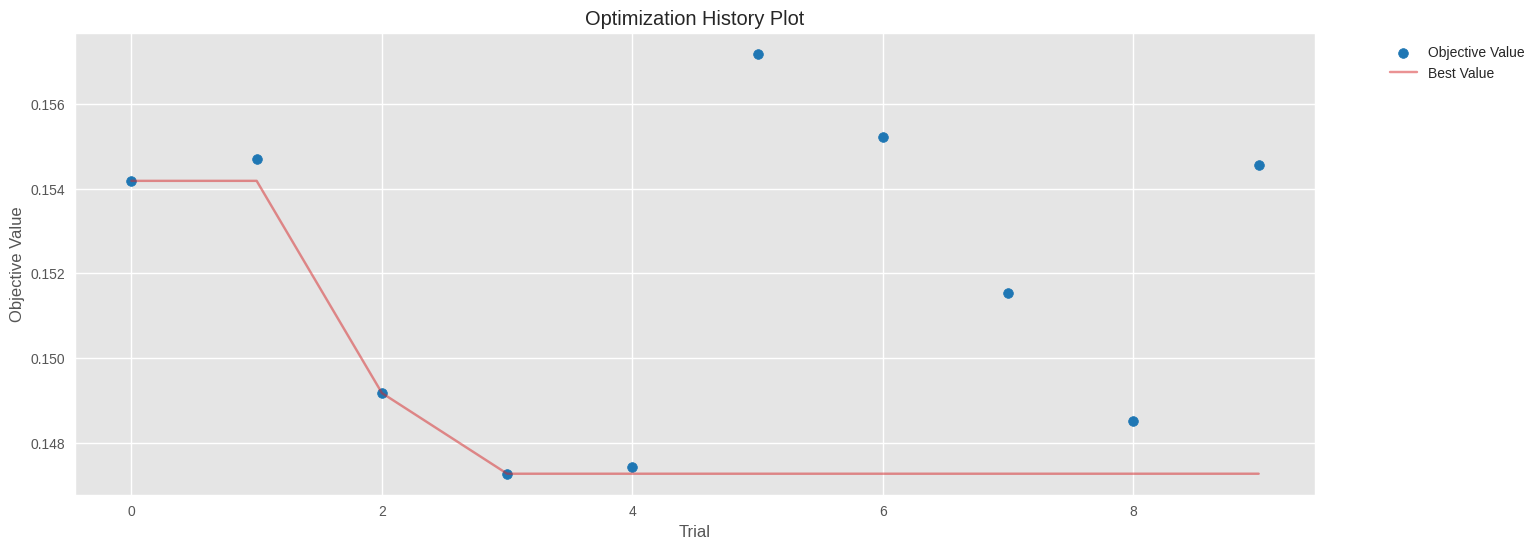

In [32]:
plot_optimization_history(study);

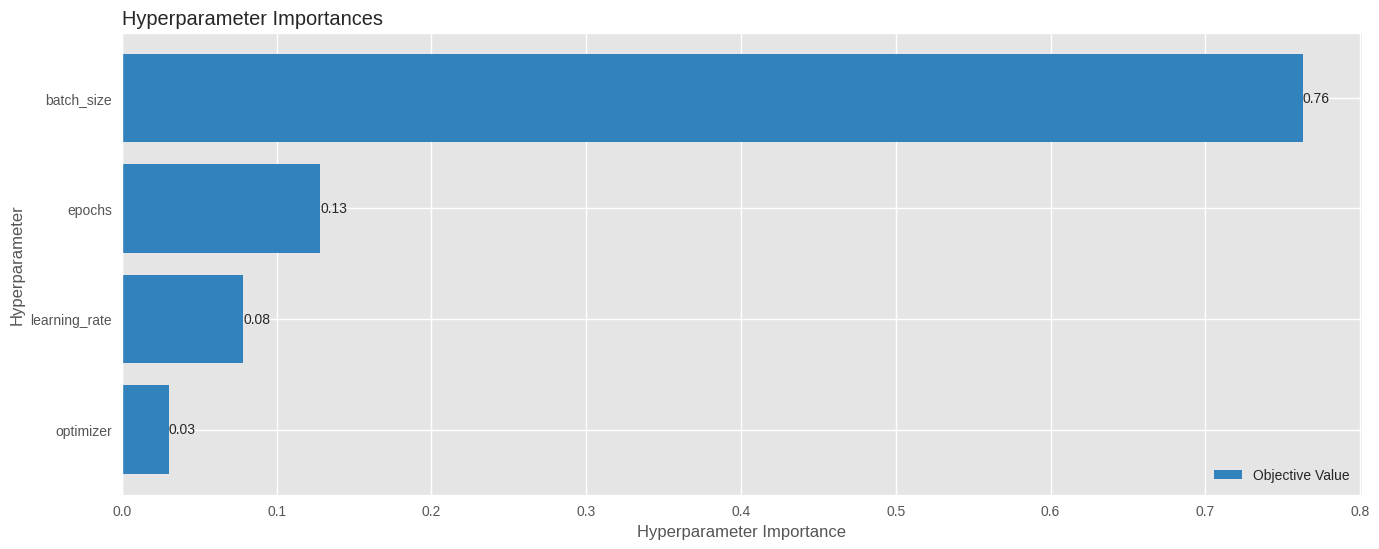

In [33]:
plot_param_importances(study);

In [34]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [35]:
# Define the LSTM model using the best hyperparameters
model = Sequential()
# Check if 'units' is in best_params, if not, provide a default value
units = best_params.get("units", 64)  # Default to 64 units if not found
model.add(LSTM(units=units, input_shape=(x_train.shape[1], x_train.shape[2])))

# Check if 'dropout_rate' exists in best_params before using it
if 'dropout_rate' in best_params:
    model.add(Dropout(rate=best_params["dropout_rate"]))

model.add(Dense(units=1))

# Compile the model with the best optimizer and learning rate
if best_params['optimizer'] == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


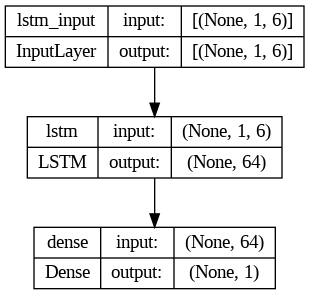

In [36]:
plot_model(model, show_shapes=True)

In [37]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 29.6 s, sys: 1.96 s, total: 31.6 s
Wall time: 27.9 s


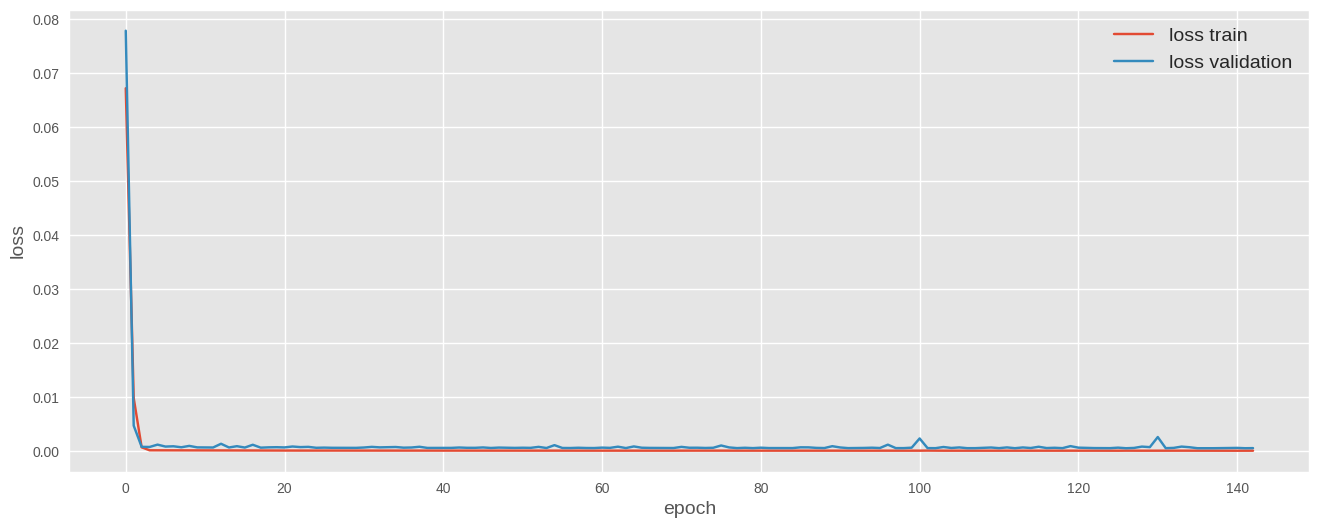

In [38]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [39]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

2/2 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 0.0000e+00


[0.0038478034548461437, 0.0]

In [40]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

3/3 [==============================] - 0s 5ms/step


In [41]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(2506,) (65,)


In [42]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [1.73677526 1.76222872 1.6848676  1.73370677 1.69752471]
Train Actual:  [2. 2. 2. 2. 2.]
Test Predicted:  [1.34255619 1.35979293 1.36578717 1.39230566 1.29487927]
Test Actual:  [1. 1. 1. 1. 1.]


In [43]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.26 RMSE
Test Score: 0.33 RMSE


In [44]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

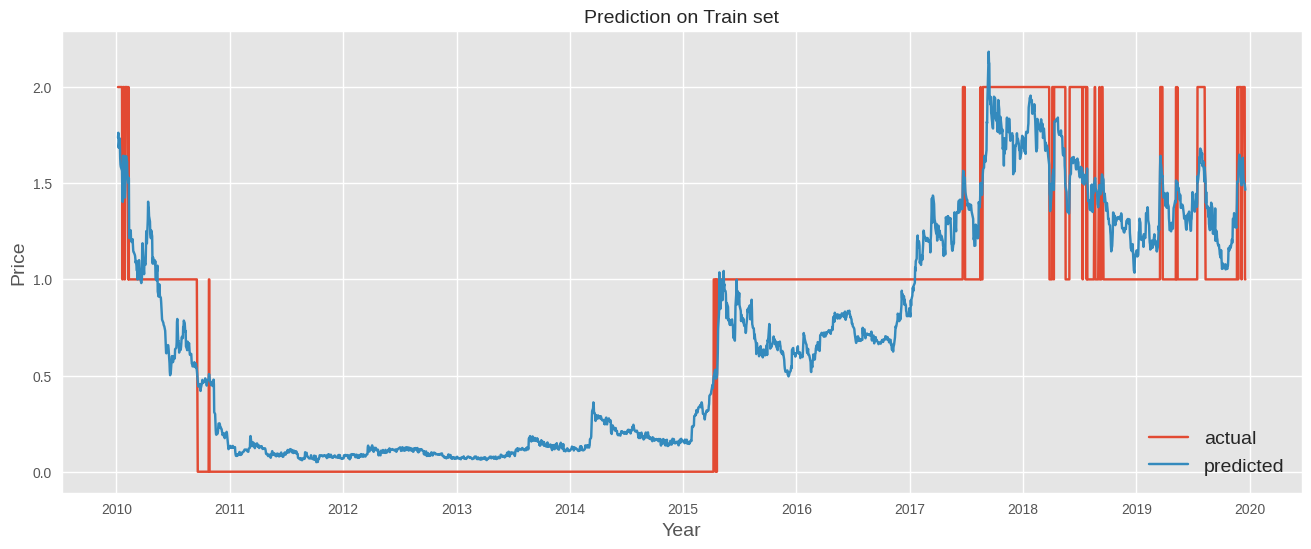

In [45]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

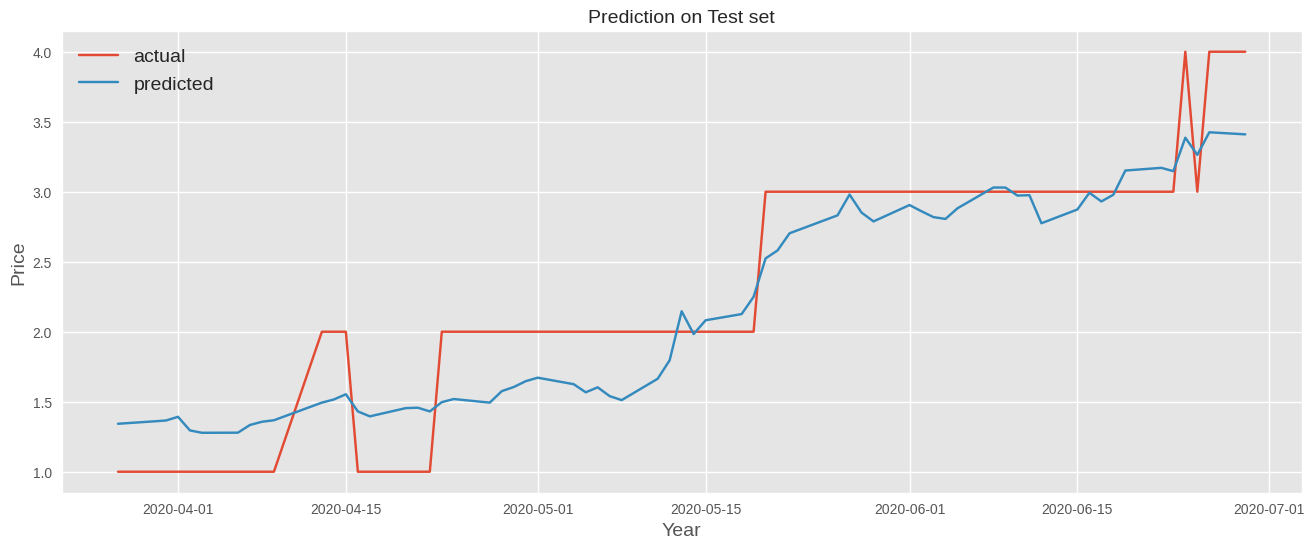

In [46]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [47]:
yhat_test

array([1.34255619, 1.35979293, 1.36578717, 1.39230566, 1.29487927,
       1.27814108, 1.27888689, 1.33383689, 1.35682035, 1.36762873,
       1.49363862, 1.51610439, 1.55333132, 1.43074768, 1.39549544,
       1.45441071, 1.45720448, 1.43079127, 1.49704235, 1.51924876,
       1.49349937, 1.57551002, 1.60508139, 1.64680533, 1.67163178,
       1.62525194, 1.56734745, 1.60273776, 1.53974543, 1.51168066,
       1.66402789, 1.79613807, 2.14611051, 1.98331733, 2.08178819,
       2.12601934, 2.24944914, 2.52372726, 2.58084247, 2.70323222,
       2.83126157, 2.97995794, 2.85092472, 2.78793174, 2.90478287,
       2.86043043, 2.81849853, 2.8056785 , 2.88152092, 3.03021651,
       3.02965874, 2.97256748, 2.97539431, 2.77483972, 2.87310887,
       2.99231183, 2.9305018 , 2.97879712, 3.15148213, 3.1705339 ,
       3.14680996, 3.38581008, 3.26345053, 3.42459527, 3.40980938])

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 0.11176111840769631
Root Mean Squared Error (RMSE): 0.3343069224645166
Mean Absolute Error (MAE): 0.28963290522123664
R-squared (R2) Score: 0.8488506001048282
Mean Absolute Percentage Error (MAPE): 17.09%


In [49]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: inf%
Mean Squared Error (MSE) on Training set: 0.07
Root Mean Squared Error (RMSE) on Training set: 0.26
Mean Absolute Error (MAE) on Training set: 0.22
R-squared (R2) Score on Training set: 0.85


In [50]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.83


In [51]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: -inf


In [52]:
# prompt: consider yhat_test as the prediction price and if the yhat_test remains under the closeness of 0.9 times of Y_test and 1.1 times of Y_test then convert it into   1 and for the rest convert it into 0, also convert each Y_test price as 1, represent both as a table

import pandas as pd
import numpy as np
yhat_test_modified = np.where((yhat_test < Y_test * 0.9) | (yhat_test > Y_test * 1.1), 0, 1)
Y_test_modified = np.ones_like(Y_test)

result_table = pd.DataFrame({'Actual Price': Y_test_modified, 'Predicted Price': yhat_test_modified})
print(result_table.head())

   Actual Price  Predicted Price
0           1.0                0
1           1.0                0
2           1.0                0
3           1.0                0
4           1.0                0


Confusion matrix:
 [[ 0  0]
 [38 27]]


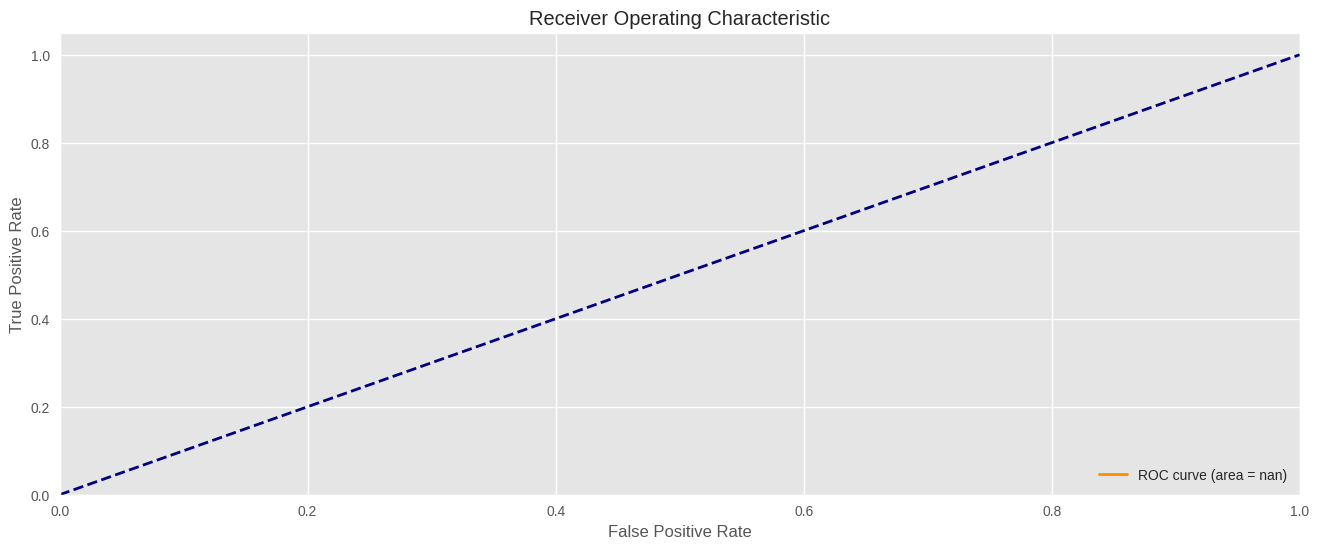

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Generate confusion matrix
cm = confusion_matrix(result_table['Actual Price'], result_table['Predicted Price'])
print("Confusion matrix:\n", cm)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(result_table['Actual Price'], result_table['Predicted Price'])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()